# Covariates - Unemployment

In [22]:
import matplotlib.pyplot as plt 
import statsmodels.formula.api as smf 
import statsmodels.api as sm

from utils import get_filtered_data, create_future_dataframe, plot_series

In [2]:
#Reading the data
df = get_filtered_data()

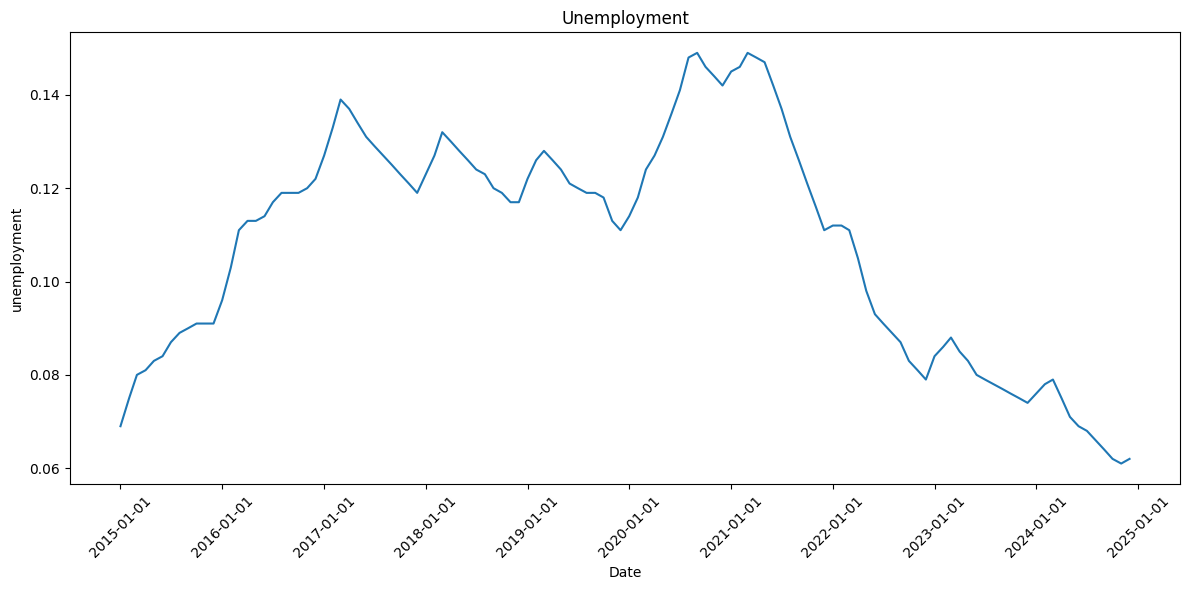

In [3]:
unemployment = df[['date', 'unemployment']] 
plot_series(unemployment, 'unemployment')

We can see from the plot above that the `unemployment` series displays a clear yearly seasonality. And from 2021 and beyond we can see a sharp decreasing trend in unemployment.

Even though there's some aparent seasonality, we can't model it with a Linear Model because we clearly see no linear trend. 

But, on alternative is to filter the data starting out in 2021 or 2022 and then try to model it using a linear model.

## Filtering 

Since the time-series behaves so differently, we can filter the values only for 2022, 2023 and 2024 and we can continue from that historical data because we know that the unemployment rate in Brazil probably won't go back to the values of 2015 very soon. 

That information is a pure biased guess, because I'm Brazilian and I've been living here since always :)

In [37]:
filtered_unemployment = unemployment[unemployment.date.dt.year > 2020]

## Basic Linear Regression Model

In [16]:
filtered_unemployment = (
    filtered_unemployment
    .assign(
        t = range(len(filtered_unemployment)),
        month = filtered_unemployment["date"].dt.month
    )
)

# Fit linear regression with trend + seasonal dummies
model_unemployment = smf.ols("unemployment ~ t + C(month)", data=filtered_unemployment).fit()

In [17]:
model_unemployment.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           unemployment   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     25.09
Date:                Wed, 01 Oct 2025   Prob (F-statistic):           1.14e-13
Time:                        10:59:46   Log-Likelihood:                 160.24
No. Observations:                  48   AIC:                            -294.5
Df Residuals:                      35   BIC:                            -270.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1360      0.005     25.217      0.000       0.125       0.147
C(month)[T.2]      0.0030      0.007      0.424      0.674      -0.011       0.017
C(month)[T.3]      0.0060      0.007      0.847      0.403      -0.008       0.020
C(month)[T.4]      0.0043      0.007      0.603      0.551      -0.010       0.019
C(month)[T.5]      0.0026      0.007      0.359      0.722      -0.012       0.017
C(month)[T.6]      0.0006      0.007      0.080      0.937      -0.014       0.015
C(month)[T.7]   8.333e-05      0.007      0.012      0.991      -0.014       0.015
C(month)[T.8]     -0.0009      0.007     -0.126      0.900      -0.015       0.014
C(month)[T.9]     -0.0016      0.007     -0.229      0.820      -0.016       0.013
C(month)[T.10]    -0.0029      0.007     -0.400      0.691      -0.017       0.012
C(month)[T.11]    -0.0034      0.007     -0.467      0.643      -0.018       0.011
C(month)[T.12]    -0.0033      0.007     -0.464      0.645      -0.018       0.011
t                 -0.0018      0.000    -16.301      0.000      -0.002      -0.002
==============================================================================
Omnibus:                       10.672   Durbin-Watson:                   0.039
Prob(Omnibus):                  0.005   Jarque-Bera (JB):                2.903
Skew:                          -0.098   Prob(JB):                        0.234
Kurtosis:                       1.811   Cond. No.                         341.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Visualizing the Model Fit on Training Data

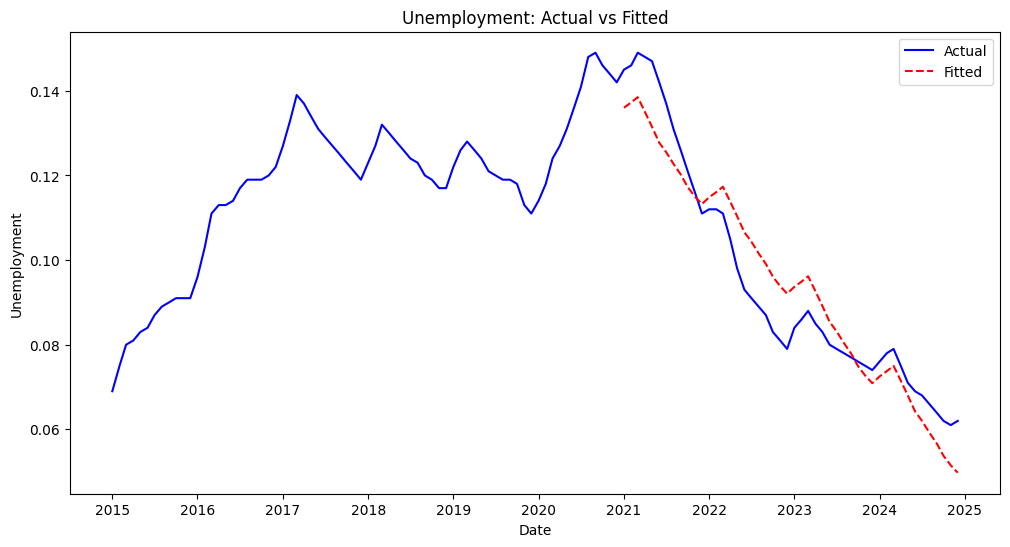

In [18]:
unemployment['fitted'] = model_unemployment.fittedvalues

# Plot actual vs fitted
plt.figure(figsize=(12, 6))
plt.plot(unemployment["date"], unemployment["unemployment"], label="Actual", color="blue")
plt.plot(unemployment["date"], unemployment["fitted"], label="Fitted", color="red", linestyle="--")

plt.title("Unemployment: Actual vs Fitted")
plt.xlabel("Date")
plt.ylabel("Unemployment")
plt.legend()
plt.show()

Indeed, a linear model models well the behaviour of the last years displaying an $R^2_{adj} = 0.9$.
But, there's a problem. 

There's no constraint for OLS models. That's why we can have negative outputs. And, we know that the Unemployment is a value $\geq0$. Actually, is very unlikely in practice to have zero unemployment rate.

With that in mind, we can look for alternatives that place such a constraint in our models. 

Like GLM with log-link functions.

But, before, let's just take a look at how the predictions with an OLS, would look like.

### Visualizing Predictions on Test Data

In [19]:
test_df = create_future_dataframe() 
test_df['unemployment'] = model_unemployment.predict(test_df) 

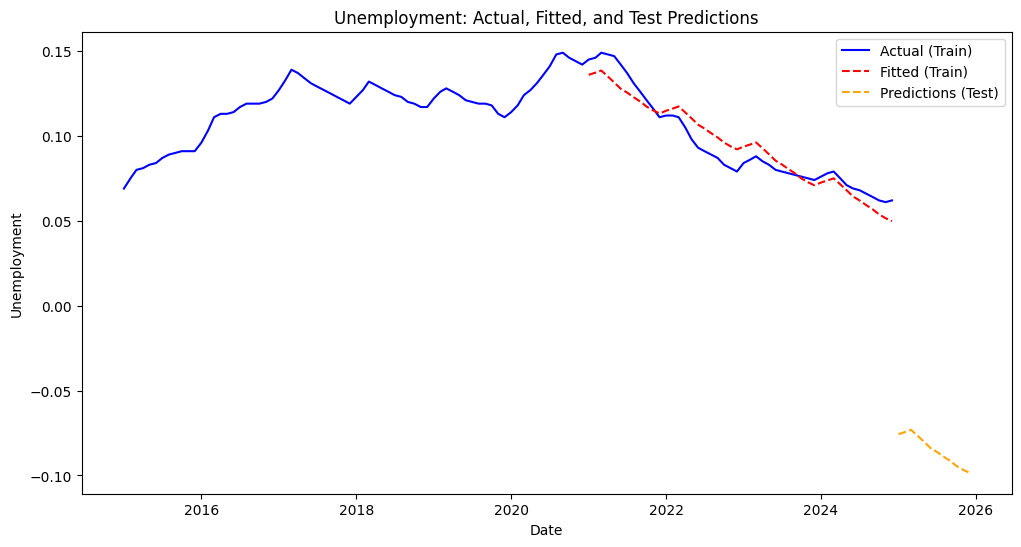

In [20]:
# Plot
plt.figure(figsize=(12, 6))

# Actual (train only)
plt.plot(unemployment["date"], unemployment["unemployment"],
         label="Actual (Train)", color="blue") 

# Fitted (train only)
plt.plot(unemployment["date"], unemployment["fitted"],
         label="Fitted (Train)", color="red", linestyle="--")

# Predictions (test only)
plt.plot(test_df["date"], test_df["unemployment"],
         label="Predictions (Test)", color="orange", linestyle="--")

plt.title("Unemployment: Actual, Fitted, and Test Predictions")
plt.xlabel("Date")
plt.ylabel("Unemployment")
plt.legend()
plt.show()

As I mentioned, negative values. We do not want it!

## GLM Model

Since our data is stored as a proportion, we can use a Beta Regression model. So we enforce that our values are inside the (0,1) interval.

### GLM with Log-link

In [38]:
family = sm.families.Gamma(link=sm.families.links.Log())
glm_res = smf.glm("unemployment ~ t + C(month)", data=filtered_unemployment, family=family).fit()

In [39]:
glm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           unemployment   No. Observations:                   48
Model:                            GLM   Df Residuals:                       35
Model Family:                   Gamma   Df Model:                           12
Link Function:                    Log   Scale:                       0.0051387
Method:                          IRLS   Log-Likelihood:                 179.35
Date:                Wed, 01 Oct 2025   Deviance:                      0.18296
Time:                        11:29:45   Pearson chi2:                    0.180
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.6678      0.078     -8.549      0.000      -0.821      -0.515
C(month)[T.2]      0.0321      0.051      0.633      0.527      -0.067       0.131
C(month)[T.3]      0.0620      0.051      1.223      0.221      -0.037       0.161
C(month)[T.4]      0.0432      0.051      0.852      0.394      -0.056       0.143
C(month)[T.5]      0.0236      0.051      0.466      0.641      -0.076       0.123
C(month)[T.6]      0.0041      0.051      0.080      0.936      -0.096       0.104
C(month)[T.7]      0.0006      0.051      0.011      0.991      -0.099       0.100
C(month)[T.8]     -0.0094      0.051     -0.184      0.854      -0.109       0.091
C(month)[T.9]     -0.0180      0.051     -0.352      0.725      -0.118       0.082
C(month)[T.10]    -0.0327      0.051     -0.640      0.522      -0.133       0.068
C(month)[T.11]    -0.0388      0.051     -0.756      0.450      -0.139       0.062
C(month)[T.12]    -0.0367      0.051     -0.713      0.476      -0.137       0.064
t                 -0.0181      0.001    -23.407      0.000      -0.020      -0.017
==================================================================================
"""

## Predictions on Training Set using GLM

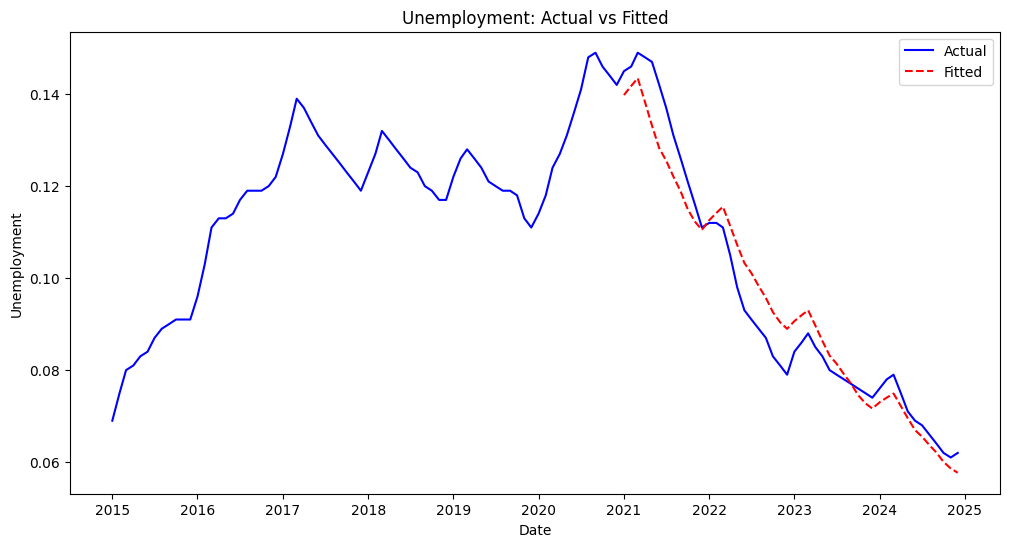

In [40]:
unemployment['glm_log'] = glm_res.fittedvalues

# Plot actual vs fitted
plt.figure(figsize=(12, 6))
plt.plot(unemployment["date"], unemployment["unemployment"], label="Actual", color="blue")
plt.plot(unemployment["date"], unemployment["glm_log"], label="Fitted", color="red", linestyle="--")

plt.title("Unemployment: Actual vs Fitted")
plt.xlabel("Date")
plt.ylabel("Unemployment")
plt.legend()
plt.show()

### GLM Predictions on Test Set

In [41]:
test_df = create_future_dataframe() 
test_df['unemployment_glm'] = glm_res.predict(test_df) 

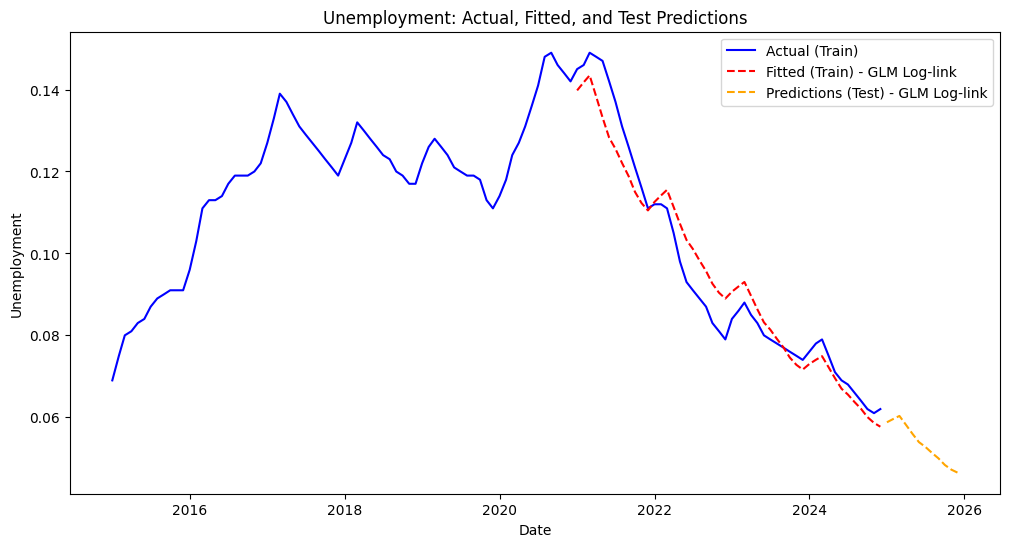

In [42]:
# Plot
plt.figure(figsize=(12, 6))

# Actual (train only)
plt.plot(unemployment["date"], unemployment["unemployment"],
         label="Actual (Train)", color="blue") 

# Fitted (train only)
plt.plot(unemployment["date"], unemployment["glm_log"],
         label="Fitted (Train) - GLM Log-link", color="red", linestyle="--")

# Predictions (test only)
plt.plot(test_df["date"], test_df["unemployment_glm"],
         label="Predictions (Test) - GLM Log-link", color="orange", linestyle="--")

plt.title("Unemployment: Actual, Fitted, and Test Predictions")
plt.xlabel("Date")
plt.ylabel("Unemployment")
plt.legend()
plt.show()

We have a much better prediction but, at the same time it's very hard to tell if the future behavior will continue to be like this.

That's why Forecasting is a never-ending process and once the model goes to production, we constantly need to check its results and update it as new data comes in.

## Saving the best model results

In [48]:
test_df.rename(columns = {"unemployment_glm":"unemployment"}, inplace=True) 
test_df[['date', 'unemployment']].to_csv("../../predictions/2025_unemployment.csv", index=False)

In [49]:
test_df[['date', 'unemployment']]

,date,unemployment
0,2025-01-01,0.058776
1,2025-02-01,0.059608
2,2025-03-01,0.060318
3,2025-04-01,0.058138
4,2025-05-01,0.055990
5,2025-06-01,0.053923
6,2025-07-01,0.052773
7,2025-08-01,0.051316
8,2025-09-01,0.049965
9,2025-10-01,0.048353
